# 1- Introduction

In this notebook, we will demonstrate how to use the awkward table and how to build selector efficiently using lambda's in python

In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
import gc
BASEDIR="/pbs/throng/training/nantes-m2-rps-exp/data"
DATATYPE="mc"
vector.register_awkward() 

First we need to identify the awkward tables as vectors

In [2]:
# file = uproot.open()
# genEvents = file["genTree"]
# events.show()

# 2- 4-momentum vector with awkward and selectors

It is possible to build an awkward table as a 4-momentum vector. To do that, you need to use the "zip" method whith px, py, pz and E as its 4 first members. You also need to call this table with the following specific name "Momentum4D"

This allow you in the following to get the kinematics of your tracks quite easily by calling:
- .p, .px, .py, .pz, .pt, ... for the momentum
- .eta for the pseudo-rapidity
- ...

Indeed, you can also add more information to the awkward table after defining the first 4 members of the table (as you can see below)

We are here implementing a "getTracks" function that will be use in the following to select tracks. See here:

In [3]:
def getTracks(events):
    return ak.zip({"px":events["Muon_Px"],
                       "py":events["Muon_Py"],
                       "pz":events["Muon_Pz"],
                       "E":events["Muon_E"],
                       "charge":events["Muon_Charge"],
                       "thetaAbs":events["Muon_thetaAbs"],
                       "matched":events["Muon_matchedTrgThreshold"]},
                    with_name='Momentum4D')

In [4]:
def getTracksGen(events):
    return ak.zip({"px":events["Muon_GenPx"],
                       "py":events["Muon_GenPy"],
                       "pz":events["Muon_GenPz"],
                       "E":events["Muon_GenE"]},
                    with_name='Momentum4D')

Now we will design a function to run over the data with uproot. 
In the iterate, we define all the variable we want to access for each events

We first select good events and track using lambdas in python. What is a good event or a good track will be define later when we call the function "scan"

In [56]:
def scan(dataDescription, 
              hMag:hist.Hist, hPhi:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x), 
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """
    
    for batch in uproot.iterate(dataDescription,
                                ["zVtx", "isCINT","isCMUL","isCMSL","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 report=True):
        events=batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] 
        
        tracks = getTracks(goodEvents)
        # tracks = tracks[goodEvents["Muon_matchedTrgThreshold"] >= 1]
        goodTracks=tracks[trackSelector(tracks)]

        hist_test = hist.Hist(hist.axis.Regular(bins=100,start=-20,stop=20,name='$z$'))
        hist_test.fill(ak.flatten(goodTracks.z))
        
        hMag.fill(ak.flatten(goodTracks.pt))
        hPhi.fill(ak.flatten(goodTracks.phi))    

        if verbose:
            print(batch[1])
        gc.collect()


In [57]:
def scanGen(dataDescription, 
              hMag:hist.Hist, hPhi:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x), 
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """
    
    for batch in uproot.iterate(dataDescription,
                                ["Muon_GenPx","Muon_GenPy","Muon_GenPz","Muon_GenE"],                                
                                 report=True):
        events=batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] 
        
        tracks = getTracksGen(goodEvents)
        goodTracks=tracks[trackSelector(tracks)]
    
        hMag.fill(ak.flatten(goodTracks.pt))

        hPhi.fill(ak.flatten(goodTracks.phi))    

        if verbose:
            print(batch[1])
        gc.collect()


In [70]:
def myEventSelector(events):
    isCMUL = events["isCMUL"]
    charge = []
    for charges in events["Muon_Charge"]:
        if (-1 in charges) and (1 in charges):
            charge += [True]
        else:
            charge += [False]
    trg = events["Muon_matchedTrgThreshold"] >= 1 #2
    print(trg)
    z = (-10 < events["zVtx"]) & (events["zVtx"] < 10)
    return charge & z

def myTrackSelector(tracks):
    p = tracks.pt > 1
    eta = tracks.eta < -2.5
    eta2 = tracks.eta > -4
    return p & eta & eta2

We define now some histograms that we want to plot and run over the data. We do it twice for illustration purposes:
- first, we don't give any definition for the eventselector and track selector. This is equivalent to say that all events and all tracks are good
- second, we implement some definition for the lambda function to have some selection criteria on our tracks


In [71]:
%%time
## SINGLE MUON TRACK PLOTS
#No cuts
vhMagRaw = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=20,name='$pt$'))
vhPhiRaw = hist.Hist(hist.axis.Regular(bins=200,start=-22/7,stop=22/7,name=r'$\phi$'))
#Event selection
vhMagEvSel = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=20,name='$pt$'))
vhPhiEvSel = hist.Hist(hist.axis.Regular(bins=200,start=-22/7,stop=22/7,name=r'$\phi$'))

vhMagEvSel2 = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=20,name='$pt$'))
vhPhiEvSel2 = hist.Hist(hist.axis.Regular(bins=200,start=-22/7,stop=22/7,name=r'$\phi$'))

vhMagGen = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=20,name='$pt$'))
vhPhiGen = hist.Hist(hist.axis.Regular(bins=200,start=-22/7,stop=22/7,name=r'$\phi$'))

scan(dataDescription=f"{BASEDIR}/run291694.{DATATYPE}.root:eventsTree",
          hMag=vhMagRaw, hPhi=vhPhiRaw)

scanGen(dataDescription=f"{BASEDIR}/run291694.{DATATYPE}.root:genTree",
          hMag=vhMagGen, hPhi=vhPhiGen)

scan(dataDescription=f"{BASEDIR}/run291694.{DATATYPE}.root:eventsTree",
          hMag=vhMagEvSel, hPhi=vhPhiEvSel,
          eventSelector=myEventSelector,
          trackSelector=lambda x: [True]*len(x))

scan(dataDescription=f"{BASEDIR}/run291694.{DATATYPE}.root:eventsTree",
          hMag=vhMagEvSel2, hPhi=vhPhiEvSel2,
          eventSelector=lambda x: x["isCMUL"]==True,
          trackSelector=lambda x: [True]*len(x))


[[True, False], [True], [], ..., [True, True], [True, True], [True, False]]
CPU times: user 2.2 s, sys: 15.6 ms, total: 2.22 s
Wall time: 2.32 s


We can now plot the results! See from the plots that our selection removed some entries in all histograms

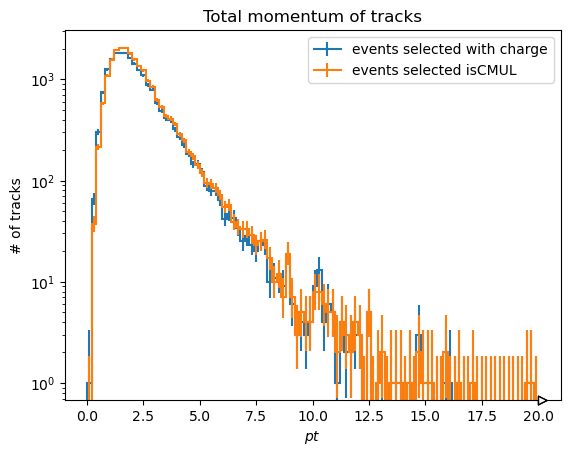

In [69]:
# vhMagRaw.plot(label="no cuts")
vhMagEvSel.plot(label="events selected with charge")
vhMagEvSel2.plot(label="events selected isCMUL")
# vhMagGen.plot(label="events generated")
plt.yscale("log")
plt.ylabel("# of tracks")
plt.title('Total momentum of tracks');
plt.legend();


                      ┌──────────────────────────────────────────────────────┐
[-inf,    0) -nan     │                                                      │
[   0,  0.2) 0.006135 │                                                      │
[ 0.2,  0.4) 0.07949  │                                                      │
[ 0.4,  0.6) 0.1808   │                                                      │
[ 0.6,  0.8) 0.3107   │                                                      │
[ 0.8,    1) 0.4148   │                                                      │
[   1,  1.2) 0.4808   │                                                      │
[ 1.2,  1.4) 0.546    │                                                      │
[ 1.4,  1.6) 0.5644   │                                                      │
[ 1.6,  1.8) 0.6357   │                                                      │
[ 1.8,    2) 0.6306   │                                                      │
[   2,  2.2) 0.6555   │                             

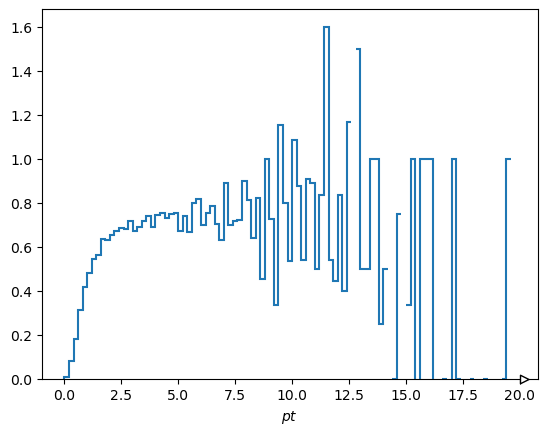

In [10]:
(vhMagRaw/vhMagGen).plot()
print(vhMagRaw/vhMagGen)

/pbs/throng/training/nantes-m2-rps-exp/micromamba/envs/qqbar2mumu-2024/lib/python3.12/site-packages/mplhep/utils.py:198: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/tmp/ipykernel_21016/3242253846.py:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


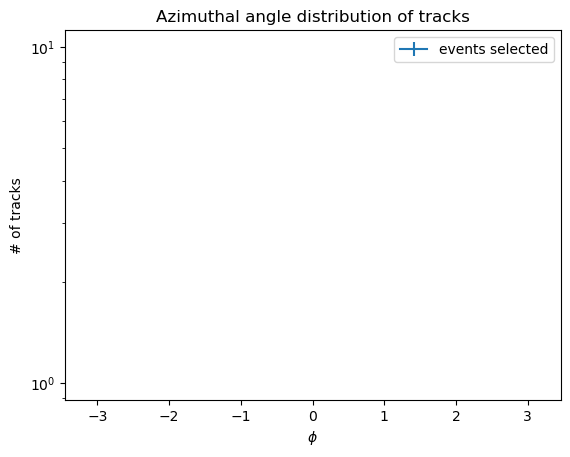

In [11]:
vhPhiEvSel.plot(label="events selected")
plt.yscale("log")
plt.ylabel("# of tracks")
plt.title('Azimuthal angle distribution of tracks');
plt.legend();